### Average ellipticity as an estimator for shear in DC2

In this notebook, we demonstrate that the average ellipticity of all galaxies in a tile is a reasonable baseline estimator for the average shear of all galaxies in the tile.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

---

First, we'll do some exploratory analysis of shear and ellipticity.

We unpack the `from_file` method of `LensingDC2Catalog` (which can be found in `lensing_dc2.py`) to read in a DC2 catalog and convert unlensed ellipticites to lensed ellipticities. We use the same calculation as [this notebook](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/matching_fof.ipynb).

In [2]:
catalog_full = pd.read_pickle('/data/scratch/dc2local/dc2_lensing_catalog_alt.pkl')

In [3]:
# for computational efficiency, we use a subset of the above data frame
catalog = catalog_full.sample(n = 100000)

In [4]:
galid = torch.from_numpy(catalog["galaxy_id"].values)
ra = torch.from_numpy(catalog["ra"].values).squeeze()
dec = torch.from_numpy(catalog["dec"].values).squeeze()

shear1 = torch.from_numpy(catalog["shear_1"].values).squeeze()
shear2 = torch.from_numpy(catalog["shear_2"].values).squeeze()
convergence = torch.from_numpy(catalog["convergence"].values)

ellip1_intrinsic = torch.from_numpy(catalog["ellipticity_1_true"].values).squeeze()
ellip2_intrinsic = torch.from_numpy(catalog["ellipticity_2_true"].values).squeeze()
ellip_intrinsic = torch.sqrt(ellip1_intrinsic ** 2 + ellip2_intrinsic ** 2)

complex_shear = shear1 + shear2 * 1j
complex_ellip = ellip1_intrinsic + ellip2_intrinsic * 1j
reduced_shear = complex_shear / (1.0 - convergence)
ellip_lensed = (complex_ellip + reduced_shear) / (1.0 + reduced_shear.conj() * complex_ellip)
ellip1_lensed = torch.view_as_real(ellip_lensed)[...,0]
ellip2_lensed = torch.view_as_real(ellip_lensed)[...,1]
ellip_lensed = torch.absolute(ellip_lensed)

We see that shear1 and shear2 are each approximately $\mathcal{N}(0, 0.02^2)$, and that they are essentially uncorrelated:

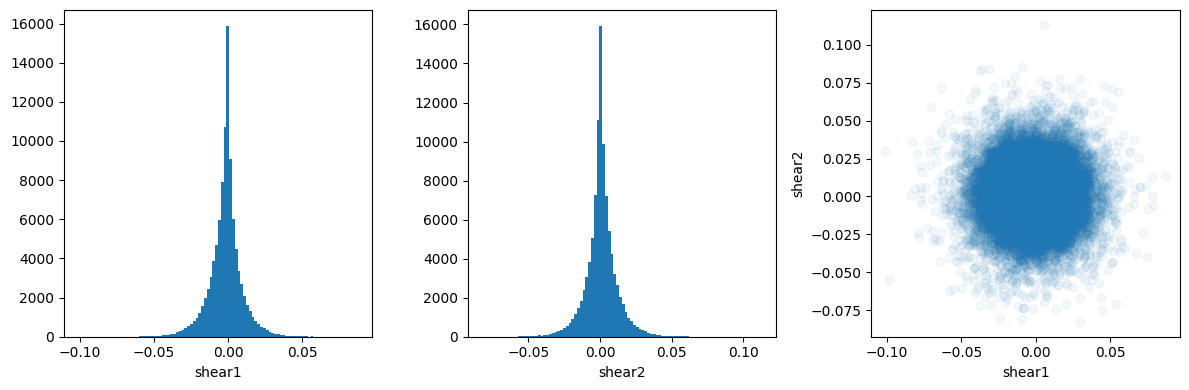

In [5]:
fig, ax = plt.subplots(1, 3, figsize = (12,4))
_ = ax[0].hist(shear1, bins = 100)
_ = ax[0].set_xlabel('shear1')
_ = ax[1].hist(shear2, bins = 100)
_ = ax[1].set_xlabel('shear2')
_ = ax[2].scatter(shear1, shear2, alpha = 0.05)
_ = ax[2].set_xlabel('shear1')
_ = ax[2].set_ylabel('shear2')
fig.tight_layout()

And we find that the two components of lensed ellipticity are each symmetrically distributed around zero, and that they are uncorrelated:

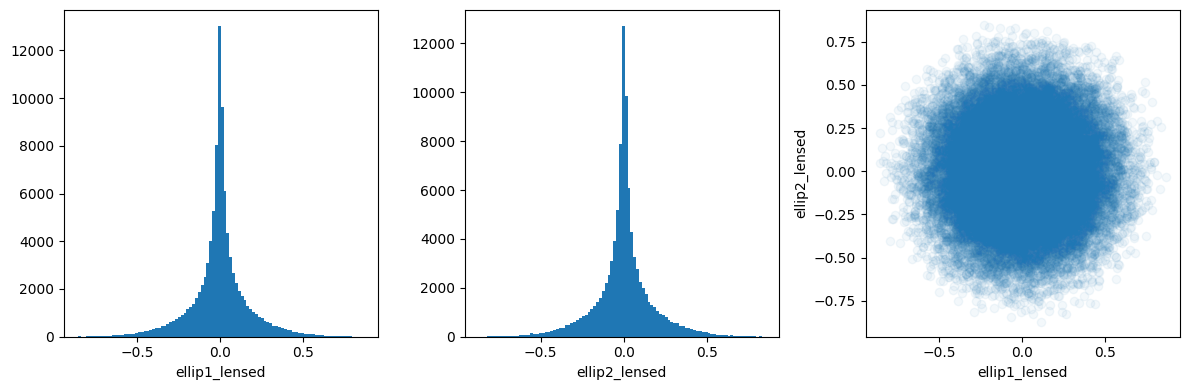

In [6]:
fig, ax = plt.subplots(1, 3, figsize = (12,4))
_ = ax[0].hist(ellip1_lensed, bins = 100)
_ = ax[0].set_xlabel('ellip1_lensed')
_ = ax[1].hist(ellip2_lensed, bins = 100)
_ = ax[1].set_xlabel('ellip2_lensed')
_ = ax[2].scatter(ellip1_lensed, ellip2_lensed, alpha = 0.05)
_ = ax[2].set_xlabel('ellip1_lensed')
_ = ax[2].set_ylabel('ellip2_lensed')
fig.tight_layout()

Next, we note that the effect of shear on ellipticity is very small, as the intrinsic and lensed ellipticity are very similar for both components:

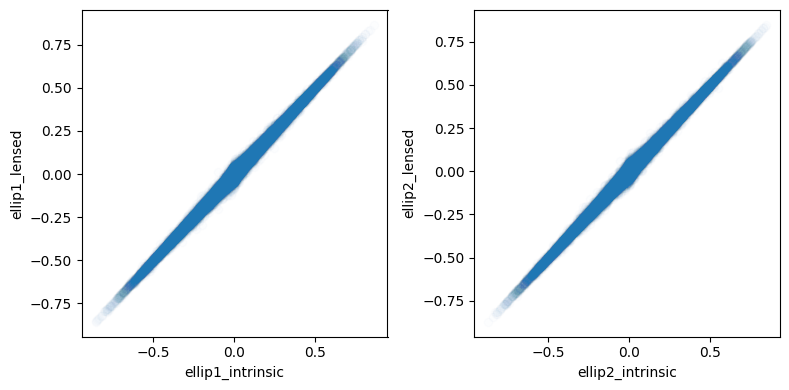

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))
_ = ax[0].scatter(ellip1_intrinsic, ellip1_lensed, alpha = 0.01)
_ = ax[0].set_xlabel('ellip1_intrinsic')
_ = ax[0].set_ylabel('ellip1_lensed')
_ = ax[1].scatter(ellip2_intrinsic, ellip2_lensed, alpha = 0.01)
_ = ax[1].set_xlabel('ellip2_intrinsic')
_ = ax[1].set_ylabel('ellip2_lensed')
fig.tight_layout()

And finally, we confirm that as the magnitude of shear increases, the absolute difference between the lensed and unlensed ellipticities also tends to increase:

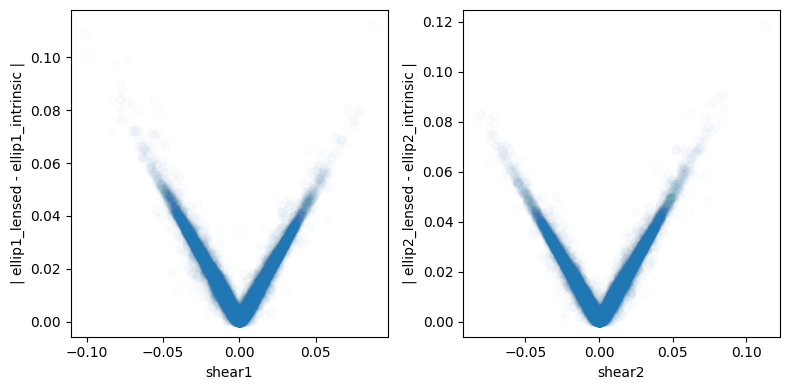

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))
_ = ax[0].scatter(shear1, (ellip1_lensed - ellip1_intrinsic).abs(), alpha = 0.01)
_ = ax[0].set_xlabel('shear1')
_ = ax[0].set_ylabel('| ellip1_lensed - ellip1_intrinsic |')
_ = ax[1].scatter(shear2, (ellip2_lensed - ellip2_intrinsic).abs(), alpha = 0.01)
_ = ax[1].set_xlabel('shear2')
_ = ax[1].set_ylabel('| ellip2_lensed - ellip2_intrinsic |')
fig.tight_layout()

---

In this section, we'll examine a single 2056 $\times$ 2056 pixel image. We'll break it into 8 $\times$ 8 tiles of size 256 $\times$ 256, and we'll compute the average shear and ellipticity of the galaxies in each tile. For ellipticity, we compute a weighted average across neighboring tiles using a Gaussian kernel. 

In [9]:
from hydra import initialize, compose
from hydra.utils import instantiate
from bliss.surveys.dc2 import split_tensor, unpack_dict
from case_studies.weak_lensing.utils.weighted_avg_ellip import compute_weighted_avg_ellip

with initialize(config_path="../../", version_base = None):
    cfg = compose("lensing_config")

In [10]:
dc2 = instantiate(cfg.surveys.dc2)
dc2._load_image_and_bg_files_list()

98

In [11]:
# this cell takes 10-20 seconds
image_index = 0
result_dict = dc2.load_image_and_catalog(image_index)

In [12]:
image = result_dict["inputs"]["image"]
tile_dict = result_dict["tile_dict"]
psf_params = result_dict["inputs"]["psf_params"]

shear1 = tile_dict["shear1_sum"] / tile_dict["shear1_count"]
shear2 = tile_dict["shear2_sum"] / tile_dict["shear2_count"]
shear = torch.stack((shear1.squeeze(-1), shear2.squeeze(-1)), dim=-1)
convergence = tile_dict["convergence_sum"] / tile_dict["convergence_count"]
ellip1_lensed = tile_dict["ellip1_lensed_sum"] / tile_dict["ellip1_lensed_count"]
ellip2_lensed = tile_dict["ellip2_lensed_sum"] / tile_dict["ellip2_lensed_count"]
ellip_lensed = torch.stack((ellip1_lensed.squeeze(-1), ellip2_lensed.squeeze(-1)), dim=-1)
redshift = tile_dict["redshift_sum"] / tile_dict["redshift_count"]

tile_dict["shear"] = shear
tile_dict["convergence"] = convergence
tile_dict["ellip_lensed"] = ellip_lensed
tile_dict["ellip_lensed_wavg"] = compute_weighted_avg_ellip(
    tile_dict, dc2.avg_ellip_kernel_size, dc2.avg_ellip_kernel_sigma
)
tile_dict["redshift"] = redshift

In [13]:
# split image
split_lim = dc2.image_lim[0] // dc2.n_image_split
image_splits = split_tensor(image, split_lim, 1, 2)
image_width_pixels = image.shape[2]
split_image_num_on_width = image_width_pixels // split_lim

# split tile cat
tile_cat_splits = {}
param_list = tile_dict.keys()
for param_name in param_list:
    tile_cat_splits[param_name] = split_tensor(
        tile_dict[param_name], split_lim // dc2.tile_slen, 0, 1
    )

data_splits = {
    "tile_catalog": unpack_dict(tile_cat_splits),
    "images": image_splits,
    "image_height_index": (
        torch.arange(0, len(image_splits)) // split_image_num_on_width
    ).tolist(),
    "image_width_index": (
        torch.arange(0, len(image_splits)) % split_image_num_on_width
    ).tolist(),
    "psf_params": [psf_params for _ in range(dc2.n_image_split**2)],
}

data_to_cache = unpack_dict(data_splits)

In [14]:
image = data_to_cache[0]['images']
tile_dict = data_to_cache[0]['tile_catalog']

In [15]:
shear = tile_dict['shear']
ellip_lensed = tile_dict['ellip_lensed']
ellip_lensed_wavg = tile_dict['ellip_lensed_wavg']

Here's the image in all 6 bands:

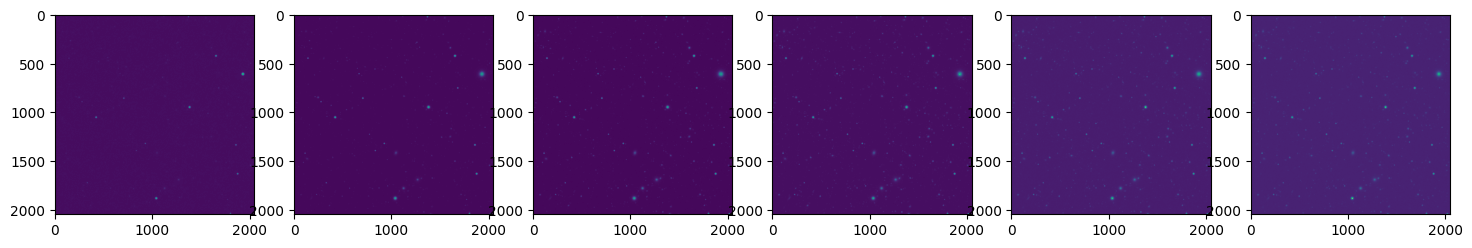

In [16]:
fig, ax = plt.subplots(1,6, figsize = (18,3))
for j in range(6):
    img = ((image[j] - image[j].min()) + 1).log().cpu()
    _ = ax[j].imshow(img.cpu())

MSE = 7.440592162311077e-05


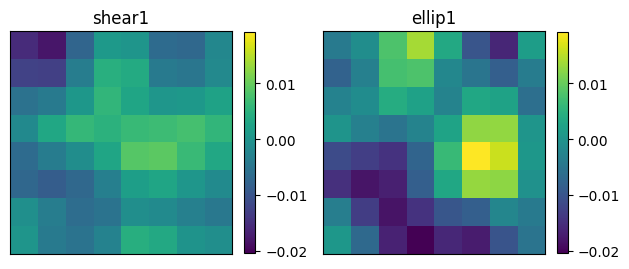

In [17]:
print(f'MSE = {((shear[...,0] - ellip_lensed_wavg[...,0]) ** 2).mean()}')

fig, ax = plt.subplots(1, 2)

vmin = min(shear[...,0].min(), ellip_lensed_wavg[...,0].min())
vmax = max(shear[...,0].max(), ellip_lensed_wavg[...,0].max())

shear1map = ax[0].imshow(shear[...,0].squeeze(),
                         vmin = vmin, vmax = vmax)
_ = plt.colorbar(shear1map, fraction = 0.045)
_ = ax[0].set_title('shear1')
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])

ellip1map = ax[1].imshow(ellip_lensed_wavg[...,0].squeeze(),
                         vmin = vmin, vmax = vmax)
_ = plt.colorbar(ellip1map, fraction = 0.045)
_ = ax[1].set_title('ellip1')
_ = ax[1].set_xticks([])
_ = ax[1].set_yticks([])
fig.tight_layout()

MSE = 0.00016180150851141661


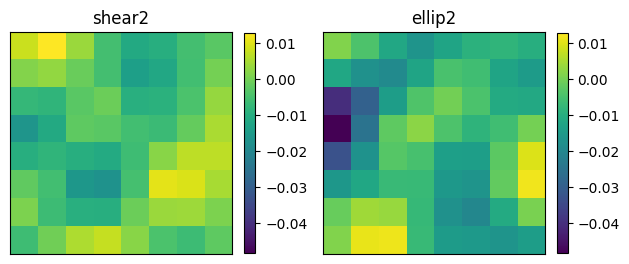

In [18]:
print(f'MSE = {((shear[...,1] - ellip_lensed_wavg[...,1]) ** 2).mean()}')

fig, ax = plt.subplots(1, 2)

vmin = min(shear[...,1].min(), ellip_lensed_wavg[...,1].min())
vmax = max(shear[...,1].max(), ellip_lensed_wavg[...,1].max())

shear1map = ax[0].imshow(shear[...,1].squeeze(),
                         vmin = vmin, vmax = vmax)
_ = plt.colorbar(shear1map, fraction = 0.045)
_ = ax[0].set_title('shear2')
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])

ellip1map = ax[1].imshow(ellip_lensed_wavg[...,1].squeeze(),
                         vmin = vmin, vmax = vmax)
_ = plt.colorbar(ellip1map, fraction = 0.045)
_ = ax[1].set_title('ellip2')
_ = ax[1].set_xticks([])
_ = ax[1].set_yticks([])
fig.tight_layout()

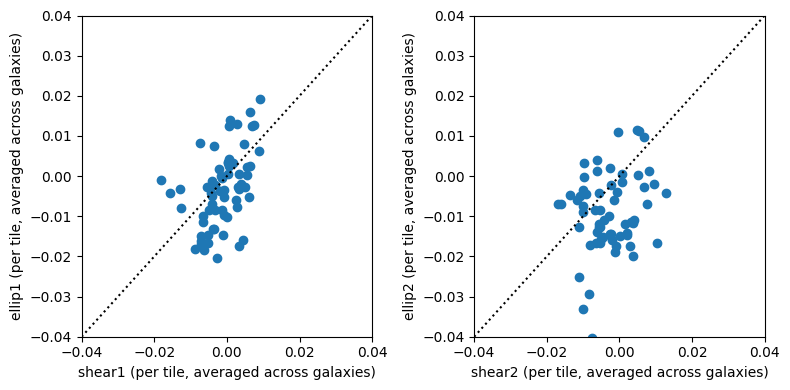

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))
_ = ax[0].scatter(shear[...,0].flatten(), ellip_lensed_wavg[...,0].flatten())
_ = ax[0].axline((0,0), slope = 1, color = 'black', linestyle = ':')
_ = ax[0].set_xlabel('shear1 (per tile, averaged across galaxies)')
_ = ax[0].set_ylabel('ellip1 (per tile, averaged across galaxies)')
_ = ax[0].set_xlim((-0.04, 0.04))
_ = ax[0].set_ylim((-0.04, 0.04))

_ = ax[1].scatter(shear[...,1].flatten(), ellip_lensed_wavg[...,1].flatten())
_ = ax[1].axline((0,0), slope = 1, color = 'black', linestyle = ':')
_ = ax[1].set_xlabel('shear2 (per tile, averaged across galaxies)')
_ = ax[1].set_ylabel('ellip2 (per tile, averaged across galaxies)')
_ = ax[1].set_xlim((-0.04, 0.04))
_ = ax[1].set_ylim((-0.04, 0.04))
fig.tight_layout()